In [1]:
import pathlib
from glob import glob
from keras.preprocessing import image

!ls -l ./img

total 24
drwxr-xr-x 2 lab11 multi 12288 Apr 16 15:53 0
drwxr-xr-x 2 lab11 multi 12288 Apr 16 15:53 1


In [2]:
163/2

81.5

In [14]:
from keras.preprocessing.image import ImageDataGenerator

# image directory
image_dir = './img_adj/img'

random_seed = 414

datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)

train_generator = datagen.flow_from_directory(image_dir,target_size = (640, 640), seed=random_seed,
                                                    batch_size = 60, class_mode = 'binary', subset='training')
valid_generator = datagen.flow_from_directory(image_dir, target_size=(640, 640), seed=random_seed,
                                              batch_size=40, class_mode='binary', subset='validation')


Found 382 images belonging to 2 classes.
Found 163 images belonging to 2 classes.


In [4]:
from tensorflow.keras.applications import ResNet50

conv_base =  ResNet50(weights='imagenet', include_top=False, input_shape =(640,640,3))

set_trainable = False

for layer in conv_base.layers:
    if layer.name =='conv5_block3_2_conv' :      
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 640, 640, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 646, 646, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 320, 320, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 320, 320, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [6]:
from keras import layers, models, optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.MaxPooling2D((3,3)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid')) 

model.summary()

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.000005), metrics=['accuracy'])    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 20, 20, 2048)      23587712  
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               18874624  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 42,462,593
Trainable params: 22,290,433
Non-trainable params: 20,172,160
_________________________________

In [7]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.33
session = InteractiveSession(config = config)

In [15]:
print(382/60)
print(163/40)

6.366666666666666
4.075


In [20]:
! time CUDA_VISIBLE_DEVICES=2 python tf_cnn_benchmarks.py --batch_size=1 --num_batches=30 --model=googlenet  --num_gpus=1 --lms=True --image_size=8192

python: can't open file 'tf_cnn_benchmarks.py': [Errno 2] No such file or directory

real	0m0.072s
user	0m0.000s
sys	0m0.017s


In [16]:
%%time

Hist = model.fit(train_generator, steps_per_epoch=6,
                epochs=50, validation_data=valid_generator, validation_steps=4) 

Epoch 1/50
6/6 [==============================] - 32s 5s/step - loss: 1.2101 - accuracy: 0.5435 - val_loss: 1.3142 - val_accuracy: 0.5063
Epoch 2/50
6/6 [==============================] - 23s 4s/step - loss: 0.9889 - accuracy: 0.5306 - val_loss: 0.7184 - val_accuracy: 0.5312
Epoch 3/50
6/6 [==============================] - 21s 4s/step - loss: 0.8874 - accuracy: 0.6118 - val_loss: 0.8111 - val_accuracy: 0.4938
Epoch 4/50
6/6 [==============================] - 21s 4s/step - loss: 0.6023 - accuracy: 0.6988 - val_loss: 0.7280 - val_accuracy: 0.5000
Epoch 5/50
6/6 [==============================] - 21s 4s/step - loss: 0.6199 - accuracy: 0.6770 - val_loss: 0.6597 - val_accuracy: 0.6125
Epoch 6/50
6/6 [==============================] - 21s 4s/step - loss: 0.5272 - accuracy: 0.7236 - val_loss: 0.7022 - val_accuracy: 0.5250
Epoch 7/50
6/6 [==============================] - 21s 4s/step - loss: 0.5450 - accuracy: 0.7081 - val_loss: 0.6945 - val_accuracy: 0.5312
Epoch 8/50
6/6 [==================

In [18]:
loss, accuracy = model.evaluate(valid_generator, steps=4)
loss, accuracy

4/4 [==============================] - 7s 2s/step - loss: 0.4911 - accuracy: 0.7750


(0.4910759925842285, 0.7749999761581421)

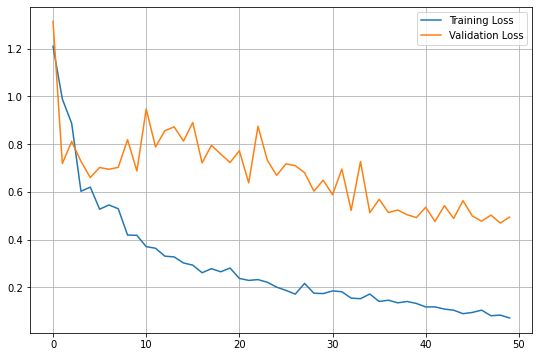

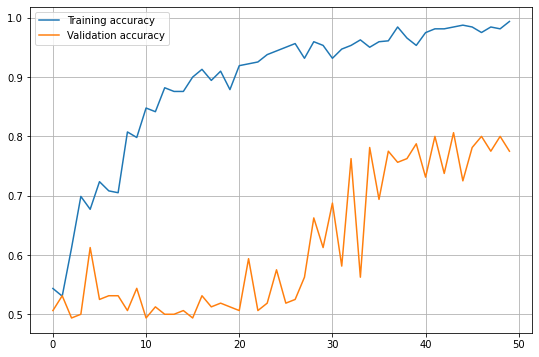

In [20]:
import matplotlib.pyplot as plt


plt.figure(figsize = (9, 6))
plt.plot(Hist.history['loss'])
plt.plot(Hist.history['val_loss'])

plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()


plt.figure(figsize = (9, 6))
plt.plot(Hist.history['accuracy'])
plt.plot(Hist.history['val_accuracy'])

plt.legend(['Training accuracy', 'Validation accuracy'])
plt.grid()
plt.show()

In [21]:
%%time

Hist = model.fit(train_generator, steps_per_epoch=6,
                epochs=150, validation_data=valid_generator, validation_steps=4) 

Epoch 1/150
6/6 [==============================] - 22s 4s/step - loss: 0.0857 - accuracy: 0.9876 - val_loss: 0.4768 - val_accuracy: 0.7875
Epoch 2/150
6/6 [==============================] - 21s 4s/step - loss: 0.0763 - accuracy: 0.9876 - val_loss: 0.4717 - val_accuracy: 0.8000
Epoch 3/150
6/6 [==============================] - 21s 4s/step - loss: 0.0805 - accuracy: 0.9876 - val_loss: 0.4801 - val_accuracy: 0.7937
Epoch 4/150
6/6 [==============================] - 21s 4s/step - loss: 0.0894 - accuracy: 0.9814 - val_loss: 0.4500 - val_accuracy: 0.8313
Epoch 5/150
6/6 [==============================] - 21s 4s/step - loss: 0.0840 - accuracy: 0.9783 - val_loss: 0.5337 - val_accuracy: 0.7500
Epoch 6/150
6/6 [==============================] - 21s 4s/step - loss: 0.0713 - accuracy: 0.9845 - val_loss: 0.4541 - val_accuracy: 0.8188
Epoch 7/150
6/6 [==============================] - 23s 4s/step - loss: 0.0690 - accuracy: 0.9889 - val_loss: 0.4912 - val_accuracy: 0.7875
Epoch 8/150
6/6 [==========

In [22]:
loss, accuracy = model.evaluate(valid_generator, steps=4)
loss, accuracy

4/4 [==============================] - 7s 2s/step - loss: 0.6052 - accuracy: 0.8188


(0.6052291989326477, 0.8187500238418579)

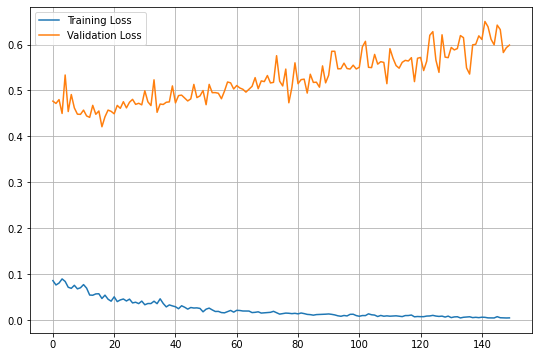

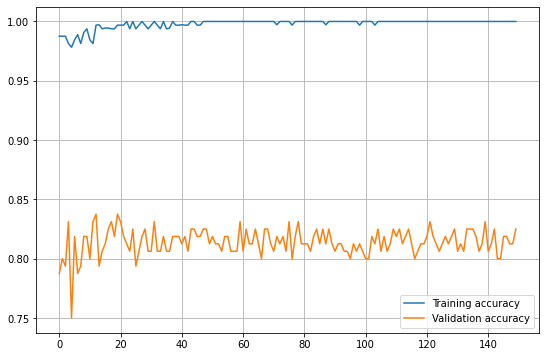

In [23]:
import matplotlib.pyplot as plt


plt.figure(figsize = (9, 6))
plt.plot(Hist.history['loss'])
plt.plot(Hist.history['val_loss'])

plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()


plt.figure(figsize = (9, 6))
plt.plot(Hist.history['accuracy'])
plt.plot(Hist.history['val_accuracy'])

plt.legend(['Training accuracy', 'Validation accuracy'])
plt.grid()
plt.show()